# Python и статистика

Проект №2 - проверка гипотез.

## Описание данных

- ```ad_id``` – идентификатор объявления (рекламы)
- ```xyz_campaign_id``` – идентификатор рекламной кампании в базе компании X
- ```fb_campaign_id``` – идентификатор кампании в Facebook
- ```age``` – возрастная группа, которой показывалась реклама
- ```gender``` – пол тех, кому показывалась реклама
- ```interest``` – код, указывающий категорию, к которой относится интерес пользователя (соответствие число – интерес)
- ```impressions``` – число показов
- ```clicks``` – число кликов
- ```spent``` – сумма, которую компания потратила на показ объявления 
- ```total_conversion``` – количество людей, которые заинтересовались продуктом после просмотра рекламы
- ```approved_conversion``` – количество людей, которые купили продукт после просмотра рекламы

## Загрузка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка и предобработка данных

In [2]:
conversion = pd.read_csv('./data/conversion.csv')

In [4]:
conversion.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


### Поиск пустых значений и дубликатов

In [5]:
# вспомогательные функции для улучшения отображения

def cols_word(n_cols: int) :
    if (n_cols % 100 > 10) and (n_cols % 100 < 20) :
        return ('колонок')
    elif (n_cols % 10 == 1) :
        return('колонка')
    elif (n_cols % 10 in [2, 3, 4]) :
        return('колонки')
    else :
        return('колонок')

def rows_word(n_rows: int) :
    if (n_rows % 100 > 10) and (n_rows % 100 < 20) :
        return ('колонок')
    elif (n_rows % 10 == 1) :
        return('строка')
    elif (n_rows % 10 in [2, 3, 4]) :
        return('строки')
    else :
        return('строк')

In [6]:
a0 = conversion.shape[0]
a1 = conversion.shape[1]
a2 = conversion.dropna().shape[0]
a3 = conversion.drop_duplicates().shape[0]

print(a0, rows_word(a0), "и", a1, cols_word(a1))
print(a2, rows_word(a2), "после удаления строк, содержащих NULL")
print(a3, rows_word(a3), "после удаления дубликатов")

1143 строки и 11 колонок
1143 строки после удаления строк, содержащих NULL
1143 строки после удаления дубликатов


### Обзор наименований колонок, типов и значений данных

In [6]:
conversion.columns

Index(['ad_id', 'xyz_campaign_id', 'fb_campaign_id', 'age', 'gender',
       'interest', 'Impressions', 'Clicks', 'Spent', 'Total_Conversion',
       'Approved_Conversion'],
      dtype='object')

In [14]:
conversion.columns = conversion.columns.str.lower()

In [15]:
conversion.dtypes

ad_id                    int64
xyz_campaign_id          int64
fb_campaign_id           int64
age                     object
gender                  object
interest                 int64
impressions              int64
clicks                   int64
spent                  float64
total_conversion         int64
approved_conversion      int64
dtype: object

## Исследование данных

Сколько уникальных рекламных кампаний было проведено?

In [16]:
conversion['xyz_campaign_id'].nunique()

3

Построим график распределения числа показов (`Impressions`) для каждой для каждой рекламной кампании в Facebook, прологарифмировав значения.

In [17]:
campaign_impressions = \
    conversion \
    .groupby('fb_campaign_id') \
    .agg({'impressions': 'sum'}) \
    .apply(lambda x: np.log(x)) \
    .rename(columns = {'impressions': 'impressions_log'})

<AxesSubplot:xlabel='impressions_log', ylabel='Count'>

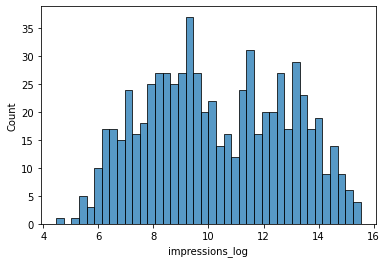

In [18]:
sns.histplot(data = campaign_impressions, x = 'impressions_log', bins = 40)

Теперь посчитаем ещё несколько полезных метрик. Первая – `CTR` (*click-through rate*), которая показывает кликабельность, т.е. отношение числа кликов к количеству показов.

In [19]:
conversion['CTR'] = conversion['clicks'] / conversion['impressions']

In [20]:
conversion['CTR'].describe()

count    1143.000000
mean        0.000164
std         0.000115
min         0.000000
25%         0.000100
50%         0.000160
75%         0.000234
max         0.001059
Name: CTR, dtype: float64

In [21]:
conversion.loc[conversion['CTR'].idxmax()]['ad_id']

738637

Визуализируем CTR с разбивкой по номеру рекламной кампании (`xyz_campaign_id`). Какому графику соответствует распределение CTR кампании 916?

<AxesSubplot:xlabel='CTR', ylabel='Count'>

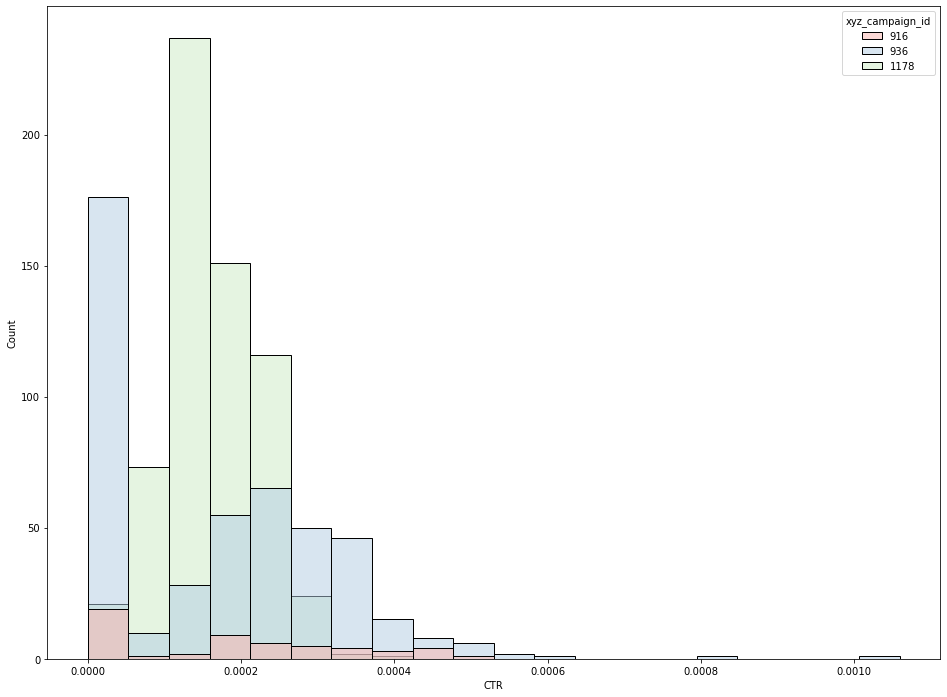

In [22]:
plt.figure(figsize=(16,12))
sns.histplot(data = conversion,
             x = 'CTR',
             hue = 'xyz_campaign_id',
             bins = 20,
             palette = 'Pastel1')

**CPC** (*cost-per-click*) – стоимость за клик пользователя по объявлению. Рассчитывается путём деления суммы потраченных денег на общее число кликов:

$$ \mbox{CPC} = \dfrac{\mbox{spent}}{\mbox{clicks}} $$

Выведем описательные статистики для новой переменной, посмотрим на форму распределения.

In [25]:
conversion['CPC'] = conversion['spent'] / conversion['clicks']

In [26]:
conversion['CPC'].describe()

count    936.000000
mean       1.499347
std        0.232879
min        0.180000
25%        1.390000
50%        1.498273
75%        1.644364
max        2.212000
Name: CPC, dtype: float64

In [27]:
round(conversion['CPC'].describe().loc['75%'] - conversion['CPC'].describe().loc['25%'], 2)

0.25

Визуализируем **CPC** с разбивкой по полу пользователей, которым были показаны объявления.

<AxesSubplot:xlabel='CPC', ylabel='Count'>

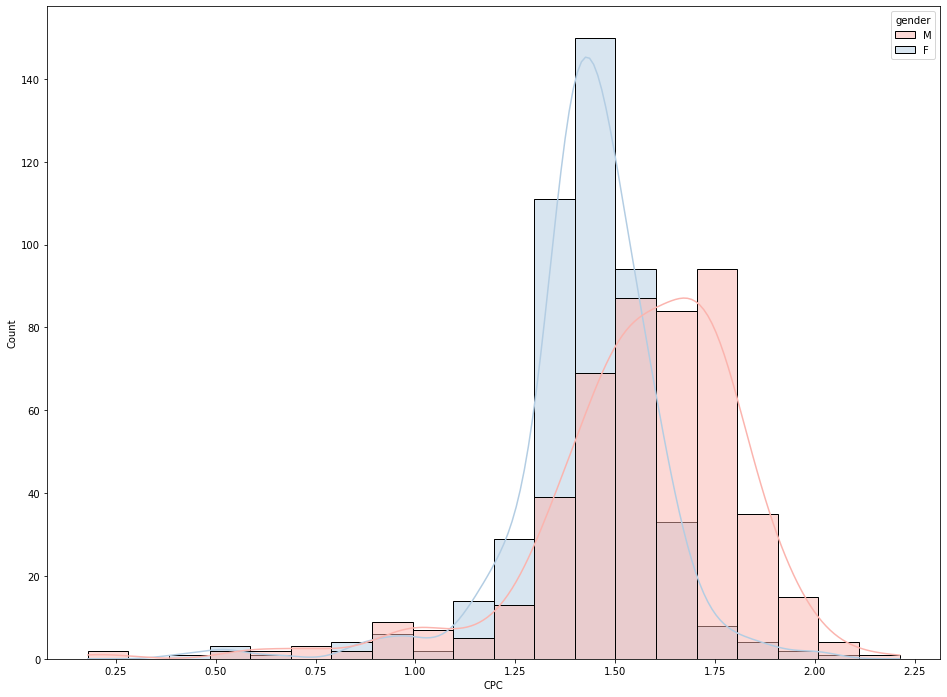

In [28]:
plt.figure(figsize=(16,12))
sns.histplot(data = conversion.dropna(),
             x = 'CPC',
             hue = 'gender',
             bins = 20,
             kde = True,
             palette = 'Pastel1')

**Конверсия** (*conversion rate*) – отношение числа пользователей, совершивших целевое действие на определенном этапе, к общему числу тех, кто дошел до данного этапа.

Посчитаем конверсию из клика в покупку. Для примера, найдём конверсию для объявления `1121814`.

*Note:* клики – `Clicks`, покупки – `Approved_Conversion`.

In [29]:
conversion['CR'] = conversion['approved_conversion'] / conversion['clicks']

In [30]:
round(100 * conversion.query("ad_id == 1121814")['CR'].item(), 2)

3.09